In [ ]:
from pyspark.sql import SparkSession
# 初始化 SparkSession
spark = SparkSession.builder.appName("TowTowerModel").config(
    "spark.driver.memory", "8g").getOrCreate()

# 加载数据集
train_df = spark.read.parquet("./train_df.parquet")
val_df = spark.read.parquet("./val_df.parquet")
user_df = spark.read.parquet("./user_df.parquet")
movie_df = spark.read.parquet("./movie_df.parquet")


In [ ]:
from pyspark.sql.functions import rand

def f(df):
    df_with_rand = df.withColumn("random", rand())

    # 使用随机数列对 DataFrame 进行排序
    random_df = df_with_rand.orderBy("random").drop("random")
    return random_df

train_df = f(train_df)
val_df = f(val_df)


In [ ]:
# 获取模型的输入维度
user_num = user_df.select('user_id').distinct().count()
age_categories = len(train_df.select("ageVector").first()[0])
occupation_categories = len(train_df.select("occupationVector").first()[0])
user_avg_rating_categories = len(train_df.select("user_avg_ratingVector").first()[0])

movie_num = movie_df.select('movie_id').distinct().count()
genres_categories = len(train_df.select("genresVector").first()[0])
movie_avg_rating_categories = len(train_df.select("movie_avg_ratingVector").first()[0])

In [ ]:
print(user_num)
print(age_categories)
print(occupation_categories)
print(user_avg_rating_categories)
print(movie_num)
print(genres_categories)
print(movie_avg_rating_categories)


In [ ]:
# import torch
# from torch.utils.data import Dataset, DataLoader

# class MovieLensDataset(Dataset):
#     def __init__(self, rdd, batch_size):
#         self.rdd = rdd
#         self.batch_size = batch_size
#         self.num_rows = rdd.count()

#     def __len__(self):
#         return (self.num_rows + self.batch_size - 1) // self.batch_size

#     def __getitem__(self, idx):
#         start = idx * self.batch_size
#         end = min(start + self.batch_size, self.num_rows)

#         # 分区读取指定范围的数据
#         data_batch = self.rdd.zipWithIndex().filter(lambda x: start <= x[1] < end).map(lambda x: x[0]).collect()

#         user_features_batch = []
#         movie_features_batch = []
#         labels_batch = []

#         for row in data_batch:
#             user_id = torch.tensor(row['user_id']).unsqueeze(0).unsqueeze(1)
#             gender = torch.tensor(row['gender']).unsqueeze(0).unsqueeze(1)
#             age_vector = torch.tensor(row['ageVector']).unsqueeze(0)
#             occupation_vector = torch.tensor(row['occupationVector']).unsqueeze(0)
#             user_avg_rating_vector = torch.tensor(row['user_avg_ratingVector']).unsqueeze(0)
#             movie_id = torch.tensor(row['movie_id']).unsqueeze(0).unsqueeze(1)
#             genres_vector = torch.tensor(row['genresVector']).unsqueeze(0)
#             movie_avg_rating_vector = torch.tensor(row['movie_avg_ratingVector']).unsqueeze(0)
#             label = torch.tensor(row['label']).unsqueeze(0)

#             # 合并user_features
#             user_features = torch.cat([user_id, gender, age_vector, occupation_vector, user_avg_rating_vector], dim=1)
#             movie_features = torch.cat([movie_id, genres_vector, movie_avg_rating_vector], dim=1)

#             user_features_batch.append(user_features)
#             movie_features_batch.append(movie_features)
#             labels_batch.append(label)

#         user_features_batch = torch.stack(user_features_batch)
#         movie_features_batch = torch.stack(movie_features_batch)
#         labels_batch = torch.stack(labels_batch)

#         return user_features_batch, movie_features_batch, labels_batch


# # 将 DataFrame 转换为 RDD
# train_rdd = train_df.rdd
# val_rdd = val_df.rdd

# # 设置 batch_size
# batch_size = 32

# # 创建 MovieLensDataset 实例
# train_dataset = MovieLensDataset(train_rdd, batch_size)
# val_dataset = MovieLensDataset(val_rdd, batch_size)

# # 创建 DataLoader
# train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)  # 会增加一个batch_size维度
# val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)


In [ ]:
import torch
import os

def save_large_data_to_multiple_files(rdd, batch_size, output_dir, base_filename):
    rdd = rdd.zipWithIndex().cache()
    num_rows = rdd.count()
    num_batches = (num_rows + batch_size - 1) // batch_size

    # 创建保存文件的目录
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # 分批保存数据
    for i in range(num_batches):
        if i == 1:
            break
        start = i * batch_size
        end = min(start + batch_size, num_rows)

        data_batch = rdd.filter(lambda x: start <= x[1] < end).map(lambda x: x[0]).collect()

        user_features_batch = []
        movie_features_batch = []
        labels_batch = []

        for row in data_batch:
            user_id = torch.tensor(row['user_id']).unsqueeze(0).unsqueeze(1)
            gender = torch.tensor(row['gender']).unsqueeze(0).unsqueeze(1)
            age_vector = torch.tensor(row['ageVector']).unsqueeze(0)
            occupation_vector = torch.tensor(row['occupationVector']).unsqueeze(0)
            user_avg_rating_vector = torch.tensor(row['user_avg_ratingVector']).unsqueeze(0)
            movie_id = torch.tensor(row['movie_id']).unsqueeze(0).unsqueeze(1)
            genres_vector = torch.tensor(row['genresVector']).unsqueeze(0)
            movie_avg_rating_vector = torch.tensor(row['movie_avg_ratingVector']).unsqueeze(0)
            label = torch.tensor(row['label']).unsqueeze(0)

            user_features = torch.cat([user_id, gender, age_vector, occupation_vector, user_avg_rating_vector], dim=1)
            movie_features = torch.cat([movie_id, genres_vector, movie_avg_rating_vector], dim=1)

            user_features_batch.append(user_features)
            movie_features_batch.append(movie_features)
            labels_batch.append(label)

        user_features_batch = torch.stack(user_features_batch)
        movie_features_batch = torch.stack(movie_features_batch)
        labels_batch = torch.stack(labels_batch)

        # 保存到 .pt 文件
        filename = f"{base_filename}_batch_{i+1}.pt"
        filepath = os.path.join(output_dir, filename)
        torch.save((user_features_batch, movie_features_batch, labels_batch), filepath)
        print(f"Saved batch {i+1}/{num_batches} to {filepath}")

# 将 DataFrame 转换为 RDD
train_rdd = train_df.rdd
val_rdd = val_df.rdd

# 参数设置
output_dir = './two_tower_data'
batch_size = 100000
base_filename = 'train_data'

# 分批保存 train_rdd
save_large_data_to_multiple_files(train_rdd, batch_size, output_dir, base_filename)
base_filename = 'val_data'
save_large_data_to_multiple_files(val_rdd, batch_size, output_dir, base_filename)


训练模型

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import os

def load_data(output_dir, base_filename, num_batches):
    all_data = []
    for i in range(num_batches):
        filepath = os.path.join(output_dir, f"{base_filename}_batch_{i+1}.pt")
        data = torch.load(filepath)
        all_data.append(data)
    
    # 将所有批次的数据堆叠起来
    all_data = [torch.cat(tensors, dim=0) for tensors in zip(*all_data)]
    dataset = TensorDataset(*all_data)
    return dataset

def get_data_loader(dataset, batch_size=64, shuffle=True):
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

train_num_batches = 27
val_num_batches = 1
# 加载数据
train_dataset = load_data('./two_tower_data', 'train_data', num_batches=train_num_batches)
val_dataset = load_data('./two_tower_data', 'val_data', num_batches=val_num_batches)

# 获取DataLoader
train_loader = get_data_loader(train_dataset, batch_size=64, shuffle=True)
val_loader = get_data_loader(val_dataset, batch_size=64, shuffle=True)  # 验证集通常不需要打乱


In [ ]:
for index, (a, b, c) in enumerate(tqdm(val_loader, desc='ValSet Eval Progress')):
    print(index, a.shape, b.shape, c.shape)
    break

In [ ]:
def print_data_loader_info(data_loader, name):
    print(f"--- {name} Info ---")
    total_batches = 0
    total_samples = 0
    for batch_idx, (user_features, movie_features, labels) in enumerate(data_loader):
        batch_size = user_features.size(0)
        total_batches += 1
        total_samples += batch_size
        print((user_features, movie_features, labels))
        break
    print(f"Total Batches: {total_batches}")
    print(f"Total Samples: {total_samples}")

# # 打印 DataLoader 的信息
print_data_loader_info(train_loader, "Train DataLoader")
print_data_loader_info(val_loader, "Validation DataLoader")

In [ ]:
# import torch
# from torch.utils.data import DataLoader, TensorDataset
# import os

# def load_multiple_batches(output_dir, base_filename, num_batches):
#     data_loaders = []
#     for i in range(num_batches):
#         filepath = os.path.join(output_dir, f"{base_filename}_batch_{i+1}.pt")
#         data = torch.load(filepath)
#         dataset = TensorDataset(data[0], data[1], data[2])
#         data_loader = DataLoader(dataset, batch_size=64, shuffle=True)
#         data_loaders.append(data_loader)
#     return data_loaders

# train_num_batches = 27
# val_num_batches = 1
# # 加载训练数据
# train_loaders = load_multiple_batches('./two_tower_data', 'train_data', num_batches=train_num_batches)
# val_loaders = load_multiple_batches('./two_tower_data', 'val_data', num_batches=val_num_batches)


In [ ]:
# class MovieLensDataset(Dataset):
#     def __init__(self, rdd, batch_size):
#         # 将RDD数据缓存到内存中
#         self.rdd = rdd.zipWithIndex().cache()
#         self.batch_size = batch_size
#         self.num_rows = self.rdd.count()

#     def __len__(self):
#         return (self.num_rows + self.batch_size - 1) // self.batch_size

#     def __getitem__(self, idx):
#         start = idx * self.batch_size
#         end = min(start + self.batch_size, self.num_rows)

#         # 直接从缓存中提取指定范围的数据
#         data_batch = self.rdd.filter(lambda x: start <= x[1] < end).map(lambda x: x[0]).collect()

#         user_features_batch = []
#         movie_features_batch = []
#         labels_batch = []

#         for row in data_batch:
#             user_id = torch.tensor(row['user_id']).unsqueeze(0).unsqueeze(1)
#             gender = torch.tensor(row['gender']).unsqueeze(0).unsqueeze(1)
#             age_vector = torch.tensor(row['ageVector']).unsqueeze(0)
#             occupation_vector = torch.tensor(row['occupationVector']).unsqueeze(0)
#             user_avg_rating_vector = torch.tensor(row['user_avg_ratingVector']).unsqueeze(0)
#             movie_id = torch.tensor(row['movie_id']).unsqueeze(0).unsqueeze(1)
#             genres_vector = torch.tensor(row['genresVector']).unsqueeze(0)
#             movie_avg_rating_vector = torch.tensor(row['movie_avg_ratingVector']).unsqueeze(0)
#             label = torch.tensor(row['label']).unsqueeze(0)

#             # 合并user_features
#             user_features = torch.cat([user_id, gender, age_vector, occupation_vector, user_avg_rating_vector], dim=1)
#             movie_features = torch.cat([movie_id, genres_vector, movie_avg_rating_vector], dim=1)

#             user_features_batch.append(user_features)
#             movie_features_batch.append(movie_features)
#             labels_batch.append(label)

#         user_features_batch = torch.stack(user_features_batch)
#         movie_features_batch = torch.stack(movie_features_batch)
#         labels_batch = torch.stack(labels_batch)

#         return user_features_batch, movie_features_batch, labels_batch


In [ ]:
# import torch
# from torch.utils.data import Dataset, DataLoader


# class MovieLensDataset(Dataset):
#     def __init__(self, rdd):
#         self.rdd = rdd
#         self.data_list = self.rdd.collect()  

#     def __len__(self):
#         return len(self.data_list)

#     def __getitem__(self, idx):
#         row = self.data_list[idx]
        
#         # 提取并转换数据为PyTorch张量
#         user_id = torch.tensor(row['user_id'], dtype=torch.int).unsqueeze(0).unsqueeze(1)
#         gender = torch.tensor(row['gender'], dtype=torch.int).unsqueeze(0).unsqueeze(1)
#         age_vector = torch.tensor(row['ageVector'], dtype=torch.int).unsqueeze(0)
#         occupation_vector = torch.tensor(row['occupationVector'], dtype=torch.int).unsqueeze(0)
#         user_avg_rating_vector = torch.tensor(row['user_avg_ratingVector'], dtype=torch.int).unsqueeze(0)
#         movie_id = torch.tensor(row['movie_id'], dtype=torch.int).unsqueeze(0).unsqueeze(1)
#         genres_vector = torch.tensor(row['genresVector'], dtype=torch.int).unsqueeze(0)
#         movie_avg_rating_vector = torch.tensor(row['movie_avg_ratingVector'], dtype=torch.int).unsqueeze(0)
#         label = torch.tensor(row['label'], dtype=torch.int).unsqueeze(0)

#         # 合并user_features
#         user_features = torch.cat([user_id, gender, age_vector, occupation_vector, user_avg_rating_vector], dim=1)
#         movie_features = torch.cat([movie_id, genres_vector, movie_avg_rating_vector], dim=1)

#         return user_features, movie_features, label

# # 创建 MovieLensDataset 实例
# train_dataset = MovieLensDataset(train_df)
# val_dataset = MovieLensDataset(val_df)

# # 创建 DataLoader
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)


In [7]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import os

def load_data(output_dir, base_filename, num_batches):
    all_data = []
    for i in range(num_batches):
        filepath = os.path.join(output_dir, f"{base_filename}_batch_{i+1}.pt")
        data = torch.load(filepath)
        all_data.append(data)
    
    # 将所有批次的数据堆叠起来
    all_data = [torch.cat(tensors, dim=0) for tensors in zip(*all_data)]
    dataset = TensorDataset(*all_data)
    return dataset

def get_data_loader(dataset, batch_size=64, shuffle=True):
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

train_num_batches = 27
val_num_batches = 1
# 加载数据
train_dataset = load_data('./two_tower_data', 'train_data', num_batches=train_num_batches)
val_dataset = load_data('./two_tower_data', 'val_data', num_batches=val_num_batches)

# 获取DataLoader
train_loader = get_data_loader(train_dataset, batch_size=32, shuffle=True)
val_loader = get_data_loader(val_dataset, batch_size=32, shuffle=True)  # 验证集通常不需要打乱


使用余弦损失的TwoTower Model

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

class FeatureEmbedder(nn.Module):
    def __init__(self, num_embeddings, embedding_dim):
        super(FeatureEmbedder, self).__init__()
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        init.normal_(self.embedding.weight, mean=0.0, std=0.01)

    def forward(self, x):
        return self.embedding(x)

class TwoTowerModel(nn.Module):
    def __init__(self, user_num, movie_num, age_categories, occupation_categories, user_avg_rating_categories,
                 genres_categories, movie_avg_rating_categories, embed_dim, hidden_dim):
        super(TwoTowerModel, self).__init__()

        # User tower
        self.user_embed = FeatureEmbedder(user_num, embed_dim)
        self.user_fc = nn.Sequential(
            nn.Linear(embed_dim + 1 + age_categories + occupation_categories + user_avg_rating_categories, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim)
        )

        # Movie tower
        self.movie_embed = FeatureEmbedder(movie_num, embed_dim)
        self.movie_fc = nn.Sequential(
            nn.Linear(embed_dim + genres_categories + movie_avg_rating_categories, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim)
        )

    def forward(self, user_features, movie_features):
        user_embedded = self.get_user_embedding(user_features)
        movie_embedded = self.get_movie_embedding(movie_features)
        # Compute cosine similarity
        cosine_similarity = torch.sum(user_embedded * movie_embedded, dim=1)
        return cosine_similarity
    
    def get_user_embedding(self, user_features):
        user_embedded = torch.cat([
            self.user_embed(user_features[:, 0].long()),
            user_features[:, 1].unsqueeze(1),
            user_features[:, 2:2 + age_categories],
            user_features[:, 2 + age_categories:2 + age_categories + occupation_categories],
            user_features[:, 2 + age_categories + occupation_categories:]
        ], dim=1).to(dtype=torch.float32)
        user_output = self.user_fc(user_embedded)
        user_output_normalized = F.normalize(user_output, p=2, dim=1)
        return user_output_normalized

    def get_movie_embedding(self, movie_features):
        movie_embedded = torch.cat([
            self.movie_embed(movie_features[:, 0].long()),
            movie_features[:, 1:1 + genres_categories],
            movie_features[:, 1 + genres_categories:]
        ], dim=1).to(dtype=torch.float32)
        movie_output = self.movie_fc(movie_embedded)
        movie_output_normalized = F.normalize(movie_output, p=2, dim=1)
        return movie_output_normalized


def cosine_loss(cos_sim, labels):
    loss = torch.where(labels == 1, 1 - cos_sim, torch.clamp(cos_sim, min=0))
    return loss.mean()


# Example usage
user_num = 6041
movie_num = 3676
age_categories = 7
occupation_categories = 21
user_avg_rating_categories = 6
genres_categories = 18
movie_avg_rating_categories = 6
embed_dim = 128
hidden_dim = 64


# Initialize the model with L2 regularization
recall_model = TwoTowerModel(
    user_num, movie_num, age_categories, occupation_categories, user_avg_rating_categories,
    genres_categories, movie_avg_rating_categories, embed_dim, hidden_dim)

使用余弦损失训练

Epoch 1/5


TrainSet Eval Progress: 100%|██████████| 82598/82598 [01:24<00:00, 975.08it/s] 


Epoch 1, Train Loss: 0.21183786044180644


ValSet Eval Progress: 100%|██████████| 2831/2831 [00:03<00:00, 841.44it/s]


Epoch 1, Val Loss: 0.2325267996461368
AUC:  0.8418379840206005


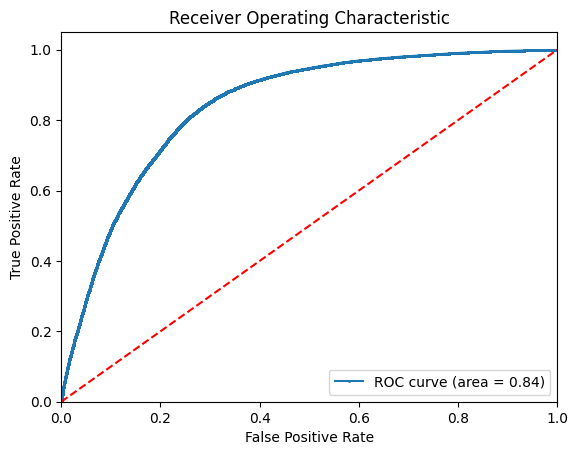

Epoch 2/5


TrainSet Eval Progress: 100%|██████████| 82598/82598 [01:22<00:00, 999.28it/s] 


Epoch 2, Train Loss: 0.2074387191835111


ValSet Eval Progress: 100%|██████████| 2831/2831 [00:02<00:00, 963.19it/s]


Epoch 2, Val Loss: 0.22721763554577565
AUC:  0.8339666154024509


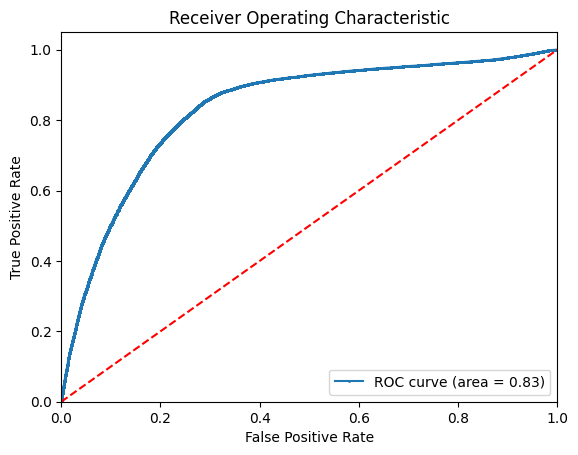

Epoch 3/5


TrainSet Eval Progress: 100%|██████████| 82598/82598 [01:21<00:00, 1014.03it/s]


Epoch 3, Train Loss: 0.20651141452201435


ValSet Eval Progress: 100%|██████████| 2831/2831 [00:02<00:00, 979.21it/s]


Epoch 3, Val Loss: 0.2267987848022977
AUC:  0.8380993061607004


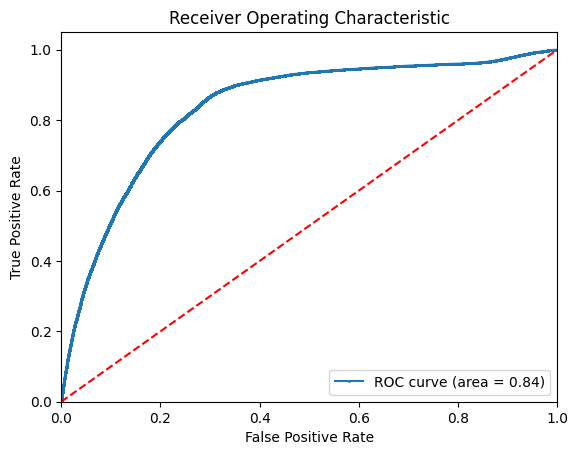

Epoch 4/5


TrainSet Eval Progress: 100%|██████████| 82598/82598 [01:22<00:00, 997.89it/s] 


Epoch 4, Train Loss: 0.20584015887453075


ValSet Eval Progress: 100%|██████████| 2831/2831 [00:02<00:00, 965.08it/s]


Epoch 4, Val Loss: 0.22577605123329988
AUC:  0.8434725570691147


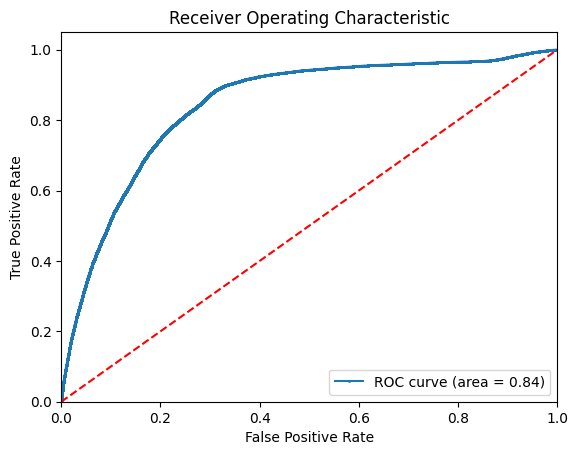

Epoch 5/5


TrainSet Eval Progress: 100%|██████████| 82598/82598 [01:47<00:00, 765.27it/s]


Epoch 5, Train Loss: 0.20557651978139035


ValSet Eval Progress: 100%|██████████| 2831/2831 [00:03<00:00, 719.76it/s]


Epoch 5, Val Loss: 0.22554074767062454
AUC:  0.8443213741170149


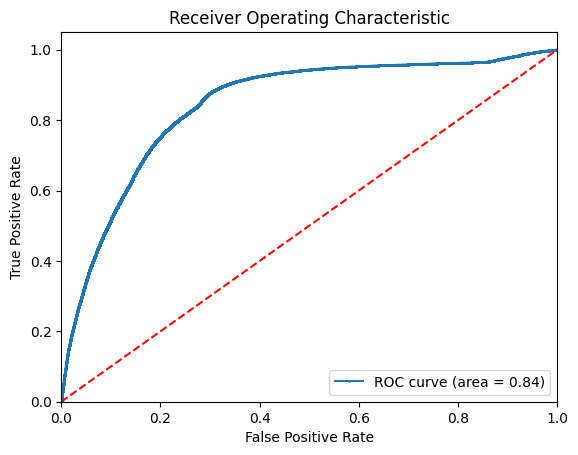

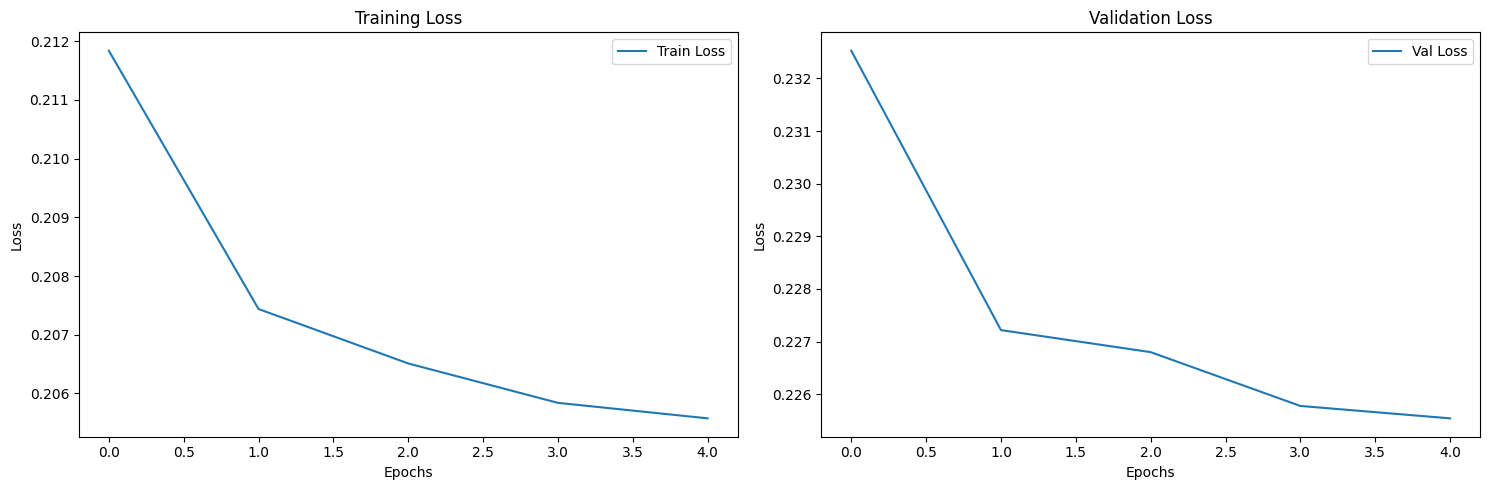

In [10]:
import matplotlib.pyplot as plt
import numpy as np  
from tqdm import tqdm  # Progress bar

def calculate_roc_curve(scores, labels):  
    """  
    计算并返回ROC曲线的TPR和FPR值。  
  
    参数:  
    - scores: numpy数组，包含样本的相似度分数（余弦相似度）。  
    - labels: numpy数组，包含与scores相对应的样本的真实标签（通常为0或1）。  
  
    返回:  
    - fpr: 假正率数组。  
    - tpr: 真正率数组。  
    - thresholds: 用于计算TPR和FPR的阈值数组（降序）。  
    """  
    # 确保标签和分数是numpy数组  
    labels = np.array(labels)  
    scores = np.array(scores)  
  
    # 计算正类和负类的索引  
    pos_labels = labels == 1  
    neg_labels = labels == -1  

    # 排序分数和对应的标签  
    sorted_indices = np.argsort(-scores)  # 按分数降序排序  
    sorted_scores = scores[sorted_indices]  
    sorted_labels = labels[sorted_indices]  

    # 初始化TPR和FPR  
    tpr = [0]  # 真正率  
    fpr = [0]  # 假正率  
    thresholds = [1.0] + list(sorted_scores)  # 阈值列表，包括一个初始的1.0（高于所有分数）  
  
    # 累积TP和FP  
    tp = 0  
    fp = 0  
    fn = np.sum(pos_labels) - tp  # 初始FN为所有正样本  
    tn = np.sum(neg_labels) - fp  # 初始TN为所有负样本  
  
    # 遍历排序后的分数（从高到低）  
    for score in sorted_scores:  
        if sorted_labels[np.where(sorted_scores == score)[0][0]] == 1:  
            tp += 1  
            fn -= 1  
        else:  
            fp += 1  
            tn -= 1  
  
        # 计算TPR和FPR  
        tpr.append(tp / (tp + fn))  
        fpr.append(fp / (fp + tn))  
  
    return fpr[:-1], tpr[:-1], thresholds[1:]  # 去除最后一个点，因为它对应所有样本都被判定为正类


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
recall_model.to(device)

# 使用混合精度训练
scaler = torch.cuda.amp.GradScaler()
optimizer = torch.optim.Adam(recall_model.parameters())

# 训练双塔模型
def train_model(model, train_loader, num_epochs=10):
    model.train()
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        for index, (user_features, movie_features, labels) in enumerate(tqdm(train_loader, desc='Training Progress')):

            user_features = user_features.squeeze(1)    # torch([32, 64])
            movie_features = movie_features.squeeze(1)  # torch([32, 64])
            labels = labels.squeeze(1)  # torch([32])
            
            user_features = user_features.to(device, non_blocking=True)
            movie_features = movie_features.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            optimizer.zero_grad()
            # cos_sim = model(user_features, movie_features)
            # loss = cosine_loss(cos_sim, labels)
            # loss.backward()
            # optimizer.step()
            # 在训练循环中使用混合精度
            with torch.cuda.amp.autocast():
                cos_sim = model(user_features, movie_features)
                loss = cosine_loss(cos_sim, labels)
            cos_sim = model(user_features, movie_features)
            # 反向传播
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        
        # 计算训练集的损失
        model.eval()
        batch_num = 0
        running_train_loss = 0.0
        with torch.no_grad():
            for index, (user_features, movie_features, labels) in enumerate(tqdm(train_loader, desc='TrainSet Eval Progress')):
                user_features = user_features.squeeze(1)    # torch([32, 64])
                movie_features = movie_features.squeeze(1)  # torch([32, 64])
                labels = labels.squeeze(1)  # torch([32])

                user_features = user_features.to(device, non_blocking=True)
                movie_features = movie_features.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)
                
                cos_sim = model(user_features, movie_features)
                train_loss = cosine_loss(cos_sim, labels)
                running_train_loss += train_loss.item()
                batch_num += 1
        
        train_losses.append(running_train_loss/batch_num)
        print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]}')

        batch_num = 0
        running_val_loss = 0.0
        all_cos_sims = []
        all_labels = []
        with torch.no_grad():
            for index, (user_features, movie_features, labels) in enumerate(tqdm(val_loader, desc='ValSet Eval Progress')):
                user_features = user_features.squeeze(1)    # torch([32, 64])
                movie_features = movie_features.squeeze(1)  # torch([32, 64])
                labels = labels.squeeze(1)  # torch([32])

                user_features = user_features.to(device, non_blocking=True)
                movie_features = movie_features.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)
                
                cos_sim = model(user_features, movie_features)
                val_loss = cosine_loss(cos_sim, labels)
                running_val_loss += val_loss.item()
                batch_num += 1
                # 收集所有预测概率和真实标签
                all_cos_sims.extend(cos_sim.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        val_losses.append(running_val_loss/batch_num)
        print(f'Epoch {epoch+1}, Val Loss: {val_losses[-1]}')

        # 计算ROC曲线  
        fpr, tpr, thresholds = calculate_roc_curve(all_cos_sims, all_labels) 
        print('AUC: ', np.trapz(tpr, fpr))
        # 绘制ROC曲线  
        plt.figure()  
        plt.plot(fpr, tpr, marker='.', markersize=2, label='ROC curve (area = %0.2f)' % np.trapz(tpr, fpr))  
        plt.plot([0, 1], [0, 1], 'r--')  
        plt.xlim([0.0, 1.0])  
        plt.ylim([0.0, 1.05])  
        plt.xlabel('False Positive Rate')  
        plt.ylabel('True Positive Rate')  
        plt.title('Receiver Operating Characteristic')  
        plt.legend(loc="lower right")  
        plt.show()
    
    # 创建一个图形和两个子图
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # 在第一个子图中绘制训练损失
    ax1.plot(train_losses, label='Train Loss')
    ax1.set_title('Training Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # 在第二个子图中绘制验证损失
    ax2.plot(val_losses, label='Val Loss')
    ax2.set_title('Validation Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()
    plt.tight_layout()  # 自动调整子图参数，使之填充整个图像区域
    plt.show()


# 训练模型
num_epochs=5
train_model(recall_model, train_loader, num_epochs)


In [19]:
# 假设 recall_model 是您已经训练好的模型
PATH = './TwoTowerModel_CosineLoss.pth'

# 保存整个模型
torch.save(recall_model, PATH)

In [20]:
import torch
# 假设 recall_model 是您已经训练好的模型
PATH = './TwoTowerModel_CosineLoss.pth'

# 加载整个模型
recall_model = torch.load(PATH)

获取用户、电影的嵌入向量

In [11]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import collect_list
import torch


# Assuming you have a Spark session
spark = SparkSession.builder.appName("EmbeddingExtraction").getOrCreate()

train_df = spark.read.parquet("./train_df.parquet")
# 使用groupBy和agg函数按用户ID分组，并将电影ID聚合为列表
user_movies_df = train_df.groupBy('user_id').agg(collect_list('movie_id').alias('movies'))
# 收集结果到驱动程序，并转换为Python字典
user_movies_dict = user_movies_df.rdd.collectAsMap()

user_df = spark.read.parquet("./user_df.parquet").toPandas()
movie_df = spark.read.parquet("./movie_df.parquet").toPandas()
val_df = spark.read.parquet("./val_df.parquet")

# Assuming you have Pandas DataFrames user_df and movie_df
# Assuming recall_model is your trained model and it's on the correct device (CPU/GPU)
device = torch.device("cpu")
recall_model.to(device)
recall_model.eval()

# Function to compute user embeddings
def compute_user_embeddings(df, model):
    user_embeddings = {}
    for index, row in df.iterrows():
        user_id = int(row['user_id'])
        user_id_tensor = torch.tensor(row['user_id']).unsqueeze(0).unsqueeze(1)
        gender_tensor = torch.tensor(row['gender']).unsqueeze(0).unsqueeze(1)
        age_vector_tensor = torch.tensor(row['ageVector']).unsqueeze(0)
        occupation_vector_tensor = torch.tensor(row['occupationVector']).unsqueeze(0)
        user_avg_rating_vector_tensor = torch.tensor(row['user_avg_ratingVector']).unsqueeze(0)  
        user_features = torch.cat([
            user_id_tensor, 
            gender_tensor, 
            age_vector_tensor, 
            occupation_vector_tensor, 
            user_avg_rating_vector_tensor
        ], dim=1)
        user_features = user_features.to(device, non_blocking=True)
        user_embedding = model.get_user_embedding(user_features)  # Modify according to your model's API
        user_embeddings[user_id] = user_embedding.squeeze(0).detach().numpy() # Convert to list if embedding is a PyTorch tensor
    return user_embeddings

# Function to compute movie embeddings
def compute_movie_embeddings(df, model):
    movie_embeddings = {}
    for index, row in df.iterrows():
        movie_id = int(row['movie_id'])
        movie_id_tensor = torch.tensor([movie_id]).unsqueeze(0)
        genres_vector_tensor = torch.tensor([row['genresVector']])
        movie_avg_rating_vector_tensor = torch.tensor([row['movie_avg_ratingVector']])
        movie_features = torch.cat([
            movie_id_tensor, 
            genres_vector_tensor, 
            movie_avg_rating_vector_tensor
        ], dim=1)
        movie_features = movie_features.to(device, non_blocking=True)
        movie_embedding = model.get_movie_embedding(movie_features)  # Modify according to your model's API
        movie_embeddings[movie_id] = movie_embedding.squeeze(0).detach().numpy() # Convert to list if embedding is a PyTorch tensor
    return movie_embeddings

# Process user_df
user_embeddings_dict = compute_user_embeddings(user_df, recall_model)

# Process movie_df
movie_embeddings_dict = compute_movie_embeddings(movie_df, recall_model)


删除用户已经评过分的电影

In [12]:
for user, _ in user_embeddings_dict.items():
    if user not in user_movies_dict.keys():
        user_movies_dict[user] = []

根据user、movie的嵌入向量计算相似度，然后根据相似度排序，返回topk个电影

In [13]:
from tqdm import tqdm
import numpy as np
from pyspark.sql.functions import collect_set, col


def compute_top_n_movies(user_embeddings_dict, movie_embeddings_dict, N):
    similarities = {}
    for user_id, user_embedding in tqdm(user_embeddings_dict.items(), desc="Computing similarities"):
        sim_list = []
        for movie_id, movie_embedding in movie_embeddings_dict.items():
            if movie_id in user_movies_dict[user_id]:
                continue
            sim = np.dot(user_embedding, movie_embedding) / (np.linalg.norm(user_embedding) * np.linalg.norm(movie_embedding))
            sim_list.append((movie_id, sim))
        # 对相似度列表按相似度降序排序，并取前100个
        similarities[user_id] = sorted(sim_list, key=lambda x: x[1], reverse=True)[:N]
    return similarities

N=1000
recommendations = compute_top_n_movies(user_embeddings_dict, movie_embeddings_dict, N)


Computing similarities: 100%|██████████| 6040/6040 [04:09<00:00, 24.22it/s]


In [21]:
import pickle


# 保存字典到文件
with open('./rectop1000_CosineLoss.pickle', 'wb') as f:
    pickle.dump(recommendations, f)

# 加载字典# with open('./rectop1000.pickle', 'rb') as f:
#     loaded_data = pickle.load(f)



In [65]:
with open('./rectop1000CosineLoss.pickle', 'rb') as f:
    loaded_data = pickle.load(f)

In [17]:
def evaluate_recall(recommendations, val_df, N=100):
    recommendations = {k: v[:N] for k, v in recommendations.items()}
    # 将推荐列表转换为 RDD
    recommendations_rdd = spark.sparkContext.parallelize(recommendations.items())

    # 计算每个用户的实际观看电影集合
    true_movies_df = val_df.where(col('label')==1).groupBy('user_id').agg(collect_set('movie_id').alias('true_movies'))
    # df_with_size = true_movies_df.withColumn("num", size(col("true_movies")))
    # # 显示结果
    # df_with_size.show()
    # 将实际观看电影集合转换为 RDD
    true_movies_rdd = true_movies_df.rdd.map(lambda row: (row['user_id'], set(row['true_movies'])))

    # 将推荐列表和实际观看电影集合进行连接
    joined_rdd = recommendations_rdd.join(true_movies_rdd)

    # 计算每个用户的召回率
    recall_per_user = joined_rdd.map(lambda kv: (
        kv[0],
        len(set([movie[0] for movie in kv[1][0]]) & kv[1][1]) / len(kv[1][1]) if len(kv[1][1]) > 0 else 0
    )).collectAsMap()

    # 计算全局召回率
    correct_recommendations = joined_rdd.map(lambda kv: len(set([movie[0] for movie in kv[1][0]]) & kv[1][1])).sum()
    total_relevant_items = joined_rdd.map(lambda kv: len(kv[1][1])).sum()
    recall = correct_recommendations / total_relevant_items if total_relevant_items > 0 else 0

    print(f'Recall@{N}: {recall:.4f}')

    # 返回全局召回率和每个用户的召回率
    return recall, recall_per_user

# 计算召回率
recall, recall_per_user = evaluate_recall(recommendations, val_df, N=300)

24/08/25 20:57:23 WARN TaskSetManager: Stage 30 contains a task of very large size (4413 KiB). The maximum recommended task size is 1000 KiB.


Recall@300: 0.4809


In [18]:
spark.stop()